## Obligasi Korporasi

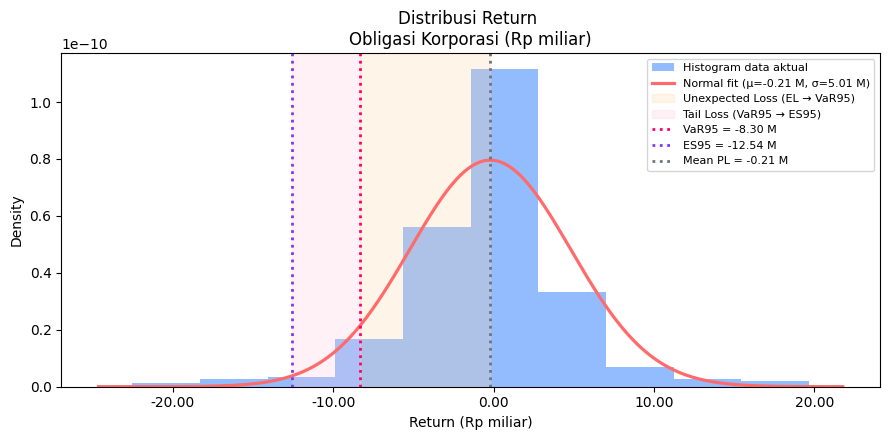

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm

# =========================
# 1. DATA & SETTINGS
# =========================

file_path = "PL_CorpBond.xlsx"      # ganti sesuai file
df = pd.read_excel(file_path)

ASSET_COL  = "PL_CorpBond"          # ganti dengan nama kolom PL
ASSET_NAME = "Obligasi Korporasi"     # nama untuk judul

if ASSET_COL not in df.columns:
    raise ValueError(f"Kolom {ASSET_COL} tidak ditemukan di file Excel.")

series = df[ASSET_COL].dropna()

# =========================
# 2. METRIK RISIKO (α = 5%)
# =========================

alpha = 0.95
mu = series.mean()
sigma = series.std(ddof=1)

q05 = series.quantile(1 - alpha)    # VaR95 di ruang PL

losses = -series
loss_q95 = np.quantile(losses, alpha)
ES95_loss = losses[losses >= loss_q95].mean()
ES95_pl = -ES95_loss

# =========================
# 3. FORMAT Rp MILIAR
# =========================

def miliar_number(x):
    """Konversi rupiah ke 'Rp miliar' dalam bentuk string, 1 desimal."""
    return f"{x / 1e9:,.2f}" 

axis_fmt = FuncFormatter(lambda val, pos: miliar_number(val))

# =========================
# 4. PALET WARNA
# =========================

hist_color   = "#3a86ff"   
fit_color    = "#ff6b6b"   
ul_color     = "#ffd6a5"   
tail_color   = "#ffc8dd"   
var_color    = "#ff006e"   
es_color     = "#8338ec"   
mean_color   = "#6c757d"   

# =========================
# 5. PLOT
# =========================

x_min = series.min()
x_max = series.max()
x_range = x_max - x_min
x = np.linspace(x_min - 0.05 * x_range,
                x_max + 0.05 * x_range,
                400)
y = norm.pdf(x, mu, sigma)

fig, ax = plt.subplots(figsize=(9, 4.5))

# Histogram
ax.hist(series,
        bins=10,
        density=True,
        alpha=0.55,
        color=hist_color,
        label="Histogram data aktual")

# Normal fit
ax.plot(x, y,
        linewidth=2.3,
        color=fit_color,
        label=f"Normal fit (μ={miliar_number(mu)} M, σ={miliar_number(sigma)} M)")

# Zona UL (EL → VaR95)
ul_left  = min(mu, q05)
ul_right = max(mu, q05)
ax.axvspan(ul_left, ul_right,
           alpha=0.25,
           color=ul_color,
           label="Unexpected Loss (EL → VaR95)")

# Zona Tail Loss (VaR95 → ES95)
tail_left  = min(q05, ES95_pl)
tail_right = max(q05, ES95_pl)
ax.axvspan(tail_left, tail_right,
           alpha=0.25,
           color=tail_color,
           label="Tail Loss (VaR95 → ES95)")

# Garis VaR95
ax.axvline(q05,
           linestyle=":",
           linewidth=2,
           color=var_color,
           label=f"VaR95 = {miliar_number(q05)} M")

# Garis ES95
ax.axvline(ES95_pl,
           linestyle=":",
           linewidth=2,
           color=es_color,
           label=f"ES95 = {miliar_number(ES95_pl)} M")

# Garis Mean
ax.axvline(mu,
           linestyle=":",
           linewidth=2,
           color=mean_color,
           label=f"Mean PL = {miliar_number(mu)} M")

# Sumbu x dalam Rp juta
ax.xaxis.set_major_formatter(axis_fmt)

ax.set_title(f"Distribusi Return \n{ASSET_NAME} (Rp miliar)")
ax.set_xlabel("Return (Rp miliar)")
ax.set_ylabel("Density")
ax.grid(False)
ax.legend(fontsize=8, frameon=True)
plt.tight_layout()
plt.show()